In [43]:
using JuMP
using GLPK
#using Xpress
using LinearAlgebra,Cbc
using Plots
import Random

## Solution for Question 1:
The dual problem is as follows: 
$$Minimise:\ 4y_1+6y_2$$
$$subject\ to:$$
$$\ y_1+2y_2\ge 4$$
$$y_1+y_2\ge 3 $$
$$y_1,y_2\ge0$$


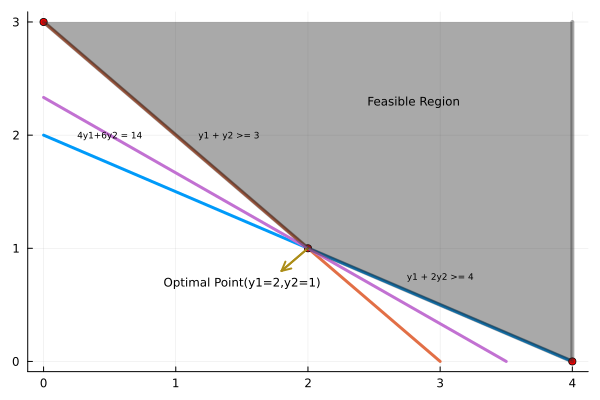

In [44]:
# Graphical Method
x1 = [4,0]; y1 = [0,2]
x2 = [3,0]; y2 = [0,3]

# Plotting constraint lines
p1 = plot(x1, y1,lw=3, annotation=[(3,0.75,"y1 + 2y2 >= 4",6)])
p2=plot!(p1, x2, y2,lw=3,annotation=[(1.4,2,"y1 + y2 >= 3",6)])

# Plotting points on the feasible region
p3=plot!(p2, [0,2,4], [3,1,0], seriestype = :scatter,legend = false,color="red")


# Plotting objective function with different values
# We keep increasing or decreasing the objective value till we find the optimal solution
obj_val = 14
x3 = [0,obj_val/4]; y3 = [obj_val/6,0]
p4=plot!(p3, x3, y3,lw=3,annotation=[(0.5,2,"4y1+6y2 = $(obj_val)",6)])

# # In practice, it is enough to figure out the two constraints whose intersection will yield the optimal solution
# # Then, compute the optimal point yourself
# # We now show the optimal point
p5=plot!(p4,[2,1.8],[1,0.8],lw=2,arrow=0.4,annotation=[(1.5,0.7,"Optimal Point(y1=2,y2=1)",8)])

# Plotting feasible region
x=[0,2,4,4]; y=[3,1,0,3]
plot!(p4,x,y,palette = cgrad(:grays),lw=4, fill = 3, α = 0.4,annotation=[(2.8,2.3,"Feasible Region",8)])

Important thing to note in the above solution is that this is a minimisation problem and the feasible space is the one above the two constraints, not below. 
The three basic feasible solutions are shown as red circles; the constraints, objective function and the optimal points are clearly marked.

## Solution to Question 2:
This is the classical vertex cover problem, where we are given a graph and we have to find a subset of vertices such that 

In [45]:
VCmodel = Model(GLPK.Optimizer)

Nodes=[1 2 3 4 5 6 7 8]     # Set of nodes
Links = [(1,2),(1,4),(1,6),(2,4),(2,3),(4,7),(3,5),(3,8),(5,8),(6,7),(7,8)] # Set of edges

n=length(Nodes)

@variable(VCmodel, x[1:n],Bin)

#The constraint is that for every edge, at least one of 
#the two incident vertices should be selected in the vertex cover
for i in 1:length(Links)
    @constraint(VCmodel,x[Links[i][1]]+x[Links[i][2]] >=1)
end

@objective(VCmodel,Min,sum(x[i] for i=1:n))

optimize!(VCmodel)
println("Objective value: ",objective_value(VCmodel))

solution = value.(x)

selected_nodes = findall(x -> x > 0, solution)
println("Nodes selected for monitoring : ", selected_nodes)
    

Objective value: 5.0
Nodes selected for monitoring : [1, 2, 3, 5, 7]


## Solution to Question 3:

An important point to note in this question is that the decision variables of the optimisation problem are the parameters of the machine learning problem. Thus, the decision variables of the optimisation problem are $a$, $b$ and $\delta$. So, while $x$ and $y$ are the variables of the machine learning problem, they are fixed vectors for the optimisation problem. 

Formulated as a linear program where $x$, $y$ refer to Height and Width respectively:

$$
\text{max}\ \ \delta\\
\text{subject to}\ \ y \geq ax + b +\delta,\ \ \forall (x,y) \in \text{Apples}\\
\ y \leq ax + b - \delta, \ \ \forall (x,y) \in \text{Pears}\\
\delta >= 0
$$

Note that $a$ and $b$ can be less than zero. There is no constraint on them.

A simpler formulation that does not need an ordering of the data can be achieved by encoding Apples = 1 and Pears = -1, and using these values to implement the constraints.

In [ ]:
training_data = [
	((60, 62), 1),
	((70, 53), -1),
	((55, 50), 1),
	((76, 40), -1),
	((68, 45), -1),
	((65, 68), 1),
	((63, 45), -1),
	((55, 56), 1),
	((68, 65), 1),
	((60, 58), 1),
]

model = Model(GLPK.Optimizer)

@variable(model, delta >= 0)
@variable(model, a)
@variable(model, b)

@objective(model, Max, delta)

for ((x, y), classification) in training_data
	if classification == 1
    	@constraint(model, y  >= (a * x + b + delta ))
	else
		@constraint(model, y  <= (a * x + b - delta ))
	end
end

optimize!(model)


if has_values(model)
    println("The problem has $(termination_status(model)) solution")
    println("Objective value (Delta): ",objective_value(model))
	println("a value: ", value(a))
	println("b value: ", value(b))
else
    println("The problem has $(termination_status(model)) solution")
end

The problem has OPTIMAL solution
Objective value (Delta): 7.115384615384615
a value: 1.153846153846154
b value: -20.576923076923087


The visualisation below was not asked in the question, but is being added for understanding the solution.

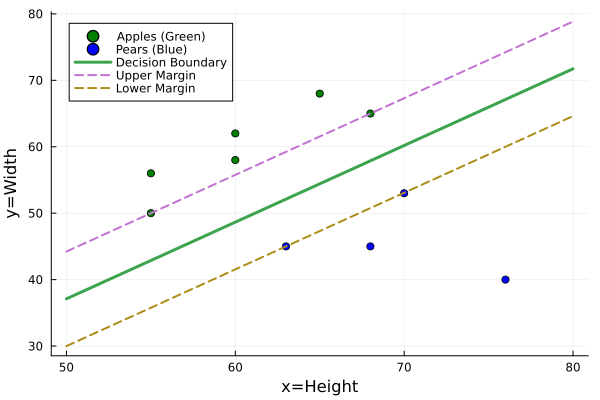

In [47]:
# Plot the points
scatter([x for ((x, _), c) in training_data if c == 1], [y for ((_, y), c) in training_data if c == 1], color=[:Green for ((x, _), c) in training_data if c == 1], label="Apples (Green)")
scatter!([x for ((x, _), c) in training_data if c == -1], [y for ((_, y), c) in training_data if c == -1], color=[:Blue for ((x, _), c) in training_data if c == -1], label="Pears (Blue)")

x1 = [50,80]; y1 = [value(a) * x_0 + value(b) for x_0 in x1]
p1 = plot!(x1, y1,lw=3, label="Decision Boundary", linestyle=:solid, linewidth=2)

# Plot the margin lines
upper_margin_y = [value(a) * x + value(b) + value(delta) for x in x1]
lower_margin_y = [value(a) * x + value(b) - value(delta) for x in x1]

plot!(x1, upper_margin_y, label="Upper Margin", linestyle=:dash, linewidth=2)
plot!(x1, lower_margin_y, label="Lower Margin", linestyle=:dash, linewidth=2)

xlabel!("x=Height")
ylabel!("y=Width")

# Display the plot
display(plot!())

Now for the quadratic part. Note that the variables for the machine learning are $x$ and $y$ values. But for the optimisation problem, the variables are $a$, $b$, $c$ and $\delta$. The constraints are quadratic for the machine learning, but are linear for the decision variables of the optimisation problem. Therefore, there is no issue in formulating this as a linear constraint since $x^2$ is just a constant for the optimisation problem. 

For the quadratic equation we can do the following to formulate it as a linear program:
$$
\text{max}\ \ \delta\\
\text{subject to}\ \ y \geq ax^2 + bx + c +\delta,\ \ \forall (x,y) \in \text{Apples}\\
\ y \leq ax^2 + bx + c - \delta, \ \ \forall (x,y) \in \text{Pears}\\
\delta >= 0
$$

Where $x,y$ refers to Height and Width respectively.
Again, note that the decision variables $a$, $b$ and $c$ can take on negative values.

In [48]:
model = Model(GLPK.Optimizer)

@variable(model, delta >= 0)
@variable(model, a)
@variable(model, b)
@variable(model, c)

@objective(model, Max, delta)

for ((x, y), classification) in training_data
	if classification == 1
		@constraint(model, y >= (a * x * x + b * x + c + delta))
	else
		@constraint(model, y <= (a * x * x + b * x + c - delta))
	end
end

optimize!(model)


if has_values(model)
	println("The problem has $(termination_status(model)) solution")
	println("Objective value (Delta): ", objective_value(model))
	println("a value: ", value(a))
	println("b value: ", value(b))
	println("c value: ", value(c))
else
	println("The problem has $(termination_status(model)) solution")
end

The problem has OPTIMAL solution
Objective value (Delta): 7.1373626373626395
a value: -0.0010989010989012058
b value: 1.2890109890110024
c value: -24.708791208791627


Again, for understanding, let's plot this. The visualisation was not required for the exam.

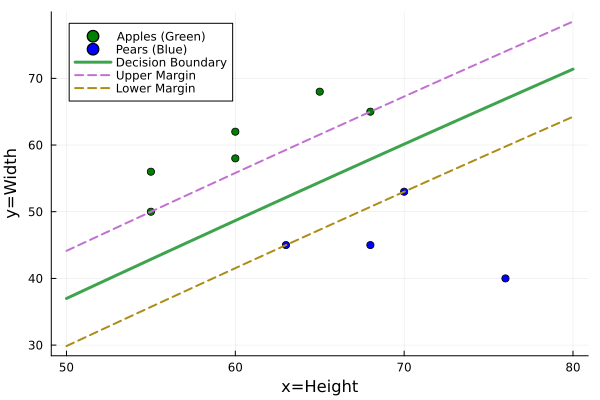

In [49]:
# Plot the points
scatter([x for ((x, _), c) in training_data if c == 1], [y for ((_, y), c) in training_data if c == 1], color = [:Green for ((x, _), c) in training_data if c == 1], label = "Apples (Green)")
scatter!([x for ((x, _), c) in training_data if c == -1], [y for ((_, y), c) in training_data if c == -1], color = [:Blue for ((x, _), c) in training_data if c == -1], label = "Pears (Blue)")

x1 = 50:80;
y1 = [value(a) * x * x + value(b) * x + value(c) for x in x1];
p1 = plot!(x1, y1, lw = 3, label = "Decision Boundary", linestyle = :solid, linewidth = 2)

# Plot the margin lines
upper_margin_y = [value(a) * x * x + value(b) * x + value(c) + value(delta) for x in x1]
lower_margin_y = [value(a) * x * x + value(b) * x + value(c) - value(delta) for x in x1]


plot!(x1, upper_margin_y, label = "Upper Margin", linestyle = :dash, linewidth = 2)
plot!(x1, lower_margin_y, label = "Lower Margin", linestyle = :dash, linewidth = 2)

xlabel!("x=Height")
ylabel!("y=Width")

# Display the plot
display(plot!())


It doesn't look quadratic because the value of the decision variable $a$ was very small. Let's add another point to make it more interesting.

The problem has OPTIMAL solution
Objective value (Delta): 6.945054945054953
a value: -0.03956043956043996
b value: 6.404395604395654
c value: -194.516483516485


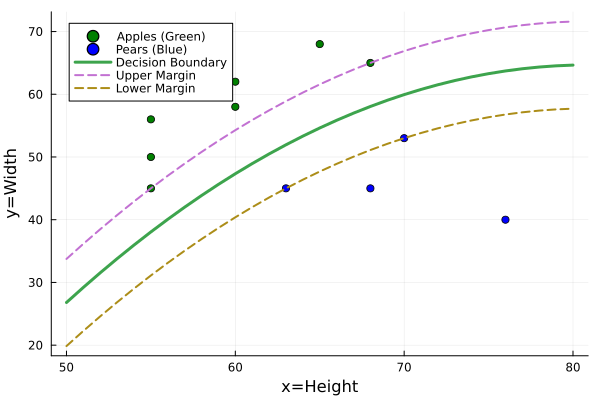

In [50]:
training_data = [
	((60, 62), 1),
	((70, 53), -1),
	((55, 50), 1),
	((76, 40), -1),
	((68, 45), -1),
	((65, 68), 1),
	((63, 45), -1),
	((55, 56), 1),
	((68, 65), 1),
	((60, 58), 1),
	((55, 45), 1), #Newly added point
]

model = Model(GLPK.Optimizer)

@variable(model, delta >= 0)
@variable(model, a)
@variable(model, b)
@variable(model, c)

@objective(model, Max, delta)

for ((x, y), classification) in training_data
	if classification == 1
		@constraint(model, y >= (a * x * x + b * x + c + delta))
	else
		@constraint(model, y <= (a * x * x + b * x + c - delta))
	end
end

optimize!(model)


if has_values(model)
	println("The problem has $(termination_status(model)) solution")
	println("Objective value (Delta): ", objective_value(model))
	println("a value: ", value(a))
	println("b value: ", value(b))
	println("c value: ", value(c))
else
	println("The problem has $(termination_status(model)) solution")
end


# Plot the points
scatter([x for ((x, _), c) in training_data if c == 1], [y for ((_, y), c) in training_data if c == 1], color = [:Green for ((x, _), c) in training_data if c == 1], label = "Apples (Green)")
scatter!([x for ((x, _), c) in training_data if c == -1], [y for ((_, y), c) in training_data if c == -1], color = [:Blue for ((x, _), c) in training_data if c == -1], label = "Pears (Blue)")

x1 = 50:80;
y1 = [value(a) * x * x + value(b) * x + value(c) for x in x1];
p1 = plot!(x1, y1, lw = 3, label = "Decision Boundary", linestyle = :solid, linewidth = 2)

# Plot the margin lines
upper_margin_y = [value(a) * x * x + value(b) * x + value(c) + value(delta) for x in x1]
lower_margin_y = [value(a) * x * x + value(b) * x + value(c) - value(delta) for x in x1]


plot!(x1, upper_margin_y, label = "Upper Margin", linestyle = :dash, linewidth = 2)
plot!(x1, lower_margin_y, label = "Lower Margin", linestyle = :dash, linewidth = 2)

xlabel!("x=Height")
ylabel!("y=Width")

# Display the plot
display(plot!())
